## Лабораторная работа № 3

Вам предоставлен набор данных, который содержит информацию о клиентах банка:
- client_id - ID клиента (неотрицательное целое число)
- Age - возраст (вещественный)
- Income - месячный доход (вещественный)
- BalanceToCreditLimit - отношение баланса на кредитной карте к лимту по кредиту (вещественный)
- DIR - Debt-to-income Ratio (вещественный)
- NumLoans - число заемов и кредитных линий
- NumRealEstateLoans - число ипотек и заемов, связанных с недвижимостью (натуральное число)
- NumDependents - число членов семьи, которых содержит клиент, исключая самого клиента (натуральное число)
- Num30-59Delinquencies - число просрочек выплат по кредиту от 30 до 59 дней (натуральное число)
- Num60-89Delinquencies - число просрочек выплат по кредиту от 60 до 89 дней (натуральное число)
- Delinquent90 - Таргет, были ли просрочки выплат по кредиту более 90 дней (бинарный)


**Задание**:
1) Анализ и предобработка.
* Проанализировать данные (EDA).
* Предобработать данные.
* Скалировать/нормализовать данные.
* Подготовить данные для обучения моделей.
2) Дерево решений.
* Обучить дерево решений, визуализировать решающее дерево
* Рассмотреть, как изменение глубины дерева влияет на качество модели. Обучите решающее дерево с различной глубиной (от 1 до 11), оцените его точность и определите, когда начинается переобучение и какая глубина дерева является оптимальной.
* Подберите оптимальные параметры дерева с помощью GridSearhCV.
3) Ансамблевые методы.
* Выберите любую классическую модель (не ансамблевую) и обучите ансамбль с помощью бэггинга (BaggingClassifier). Подберите оптимальные параметры как  бэггинга так и модели с помощью GridSearhCV.
* Выберите любые классические модели (не ансамблевые) и обучите ансамбль с помощью стекинга (StackingClassifier). Подберите оптимальные параметры как  стекинга так и модели с помощью GridSearhCV.
* Обучите cлучайный лес (RandomForestClassifier), настройте гиперпараметры случайного леса с помощью GridSearhCV.
* Инициализируете параметры и обучите классификатор XGBoost (обратите внимание, что XGBoost работает только с числовыми признаками). Вычислите F score (не F мера!) для оценки важности признаков в XGBoost.

#### 1) Анализ и предобработка:

In [129]:
import pandas as pd 

data = pd.read_csv('data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   client_id              75000 non-null  int64  
 1   DIR                    75000 non-null  float64
 2   Age                    75000 non-null  float64
 3   NumLoans               75000 non-null  int64  
 4   NumRealEstateLoans     75000 non-null  int64  
 5   NumDependents          73084 non-null  float64
 6   Num30-59Delinquencies  75000 non-null  int64  
 7   Num60-89Delinquencies  75000 non-null  int64  
 8   Income                 60153 non-null  float64
 9   BalanceToCreditLimit   75000 non-null  float64
 10  Delinquent90           75000 non-null  int64  
dtypes: float64(5), int64(6)
memory usage: 6.3 MB


Приведем значения в столбце NumDependents к типу int:

In [ ]:
data = data.astype({'NumDependents': "Int64"})

##### Гистограммы 

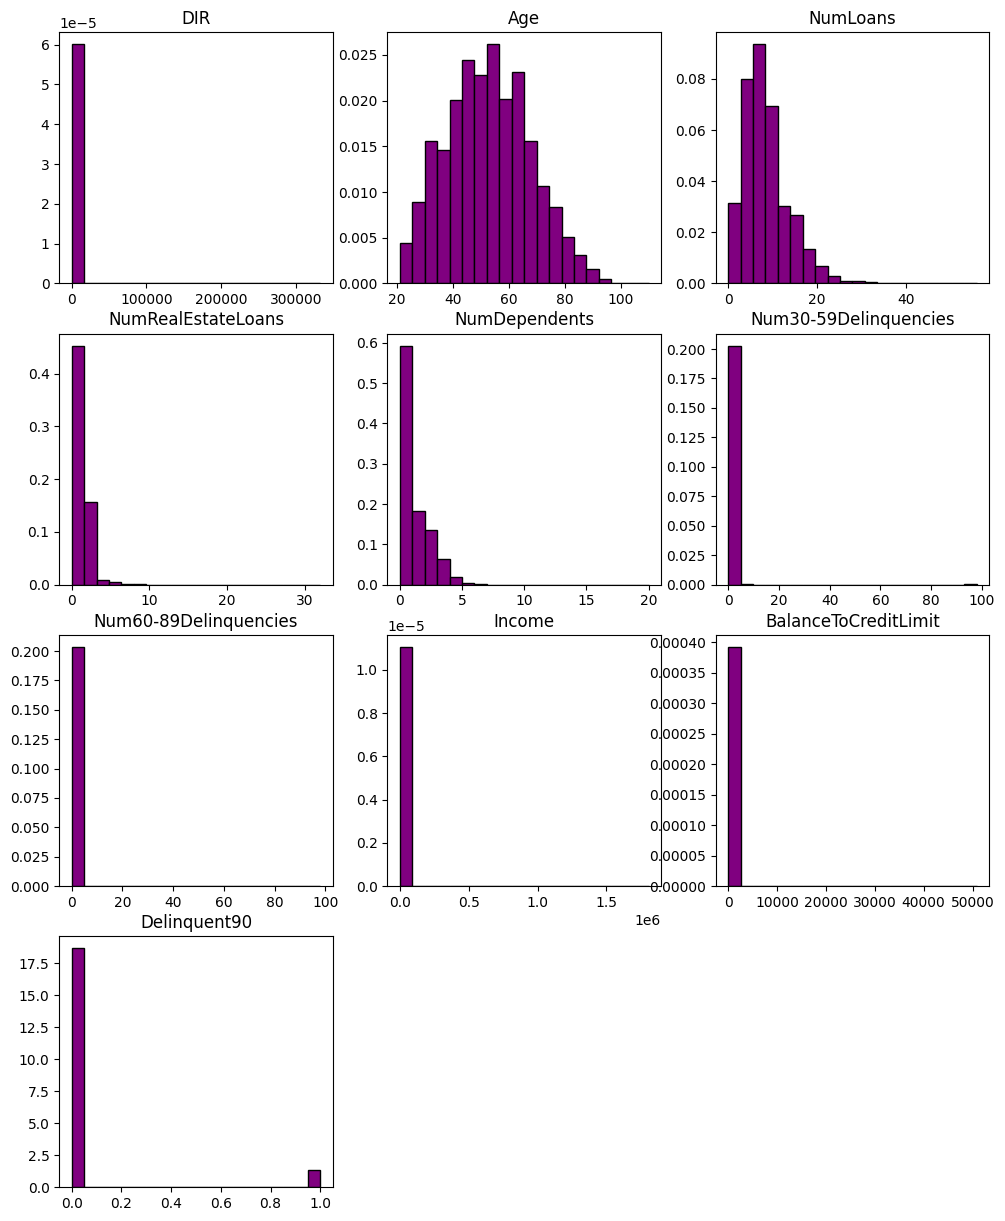

In [135]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,15))
i = 1
for column in data.columns:
    if column != 'client_id':
        plt.subplot(4, 3, i)
        plt.hist(data[column], density=True, color = 'purple', edgecolor = 'black', bins=20)
        plt.title(column)
        i += 1
plt.show()

По гистограммам видно, что 
- клиентов, у которых не было просрочек выплат по кредиту более 90 дней (таргет) больше, чем клиентов, у которых эти просрочки были  
- распределения возраста (Age) и числа заемов и кредитных линий (NumLoans) среди клиентов похоже на нормальное 
- распределения признаков NumRealEstateLoans и NumDependents похоже на логнормальное 

Про распределения остальных признаков пока сложно что-то сказать, так как, возможно, в данных присутствуют ошибки. Рассмотрим их подробнее.

Признак DIR равен отношению суммы ежемесячных платежей по долгу к ежемесечному доходу. В нашем датасете DIR может быть приведен как в процентах, так и в дробях. Приведем все значения к одному виду. Так как записей с DIR <= 1 в данных сильно больше, чем записей с DIR > 1, переведем все в дроби. Почти все полученные значения DIR <= 1 (на практике DIR может быть больше 100%). Полученное распределение похоже на нормальное с пиком около 0.

DIR before:
DIR <= 1: 57397
DIR > 1: 17603
DIR after:
DIR <= 1: 62858
DIR > 1: 12142


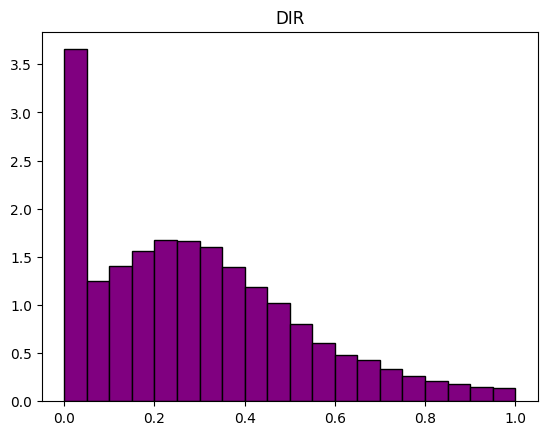

In [291]:
df = data.copy()

print('DIR before:')
print('DIR <= 1:', data[data['DIR'] <= 1].shape[0])
print('DIR > 1:', data[data['DIR'] > 1].shape[0])

df.loc[df['DIR'] > 1, 'DIR'] /= 100

plt.hist(df['DIR'][df['DIR'] <= 1], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('DIR')

print('DIR after:')
print('DIR <= 1:', df[df['DIR'] <= 1].shape[0])
print('DIR > 1:', df[df['DIR'] > 1].shape[0])

Все значения признака BalanceToCreditLimit также переведем в дроби. Почти все полученные значения BalanceToCreditLimit <= 1 (на практике BalanceToCreditLimit также может быть больше 100%).

BalanceToCreditLimit before:
<= 1: 67941
> 1: 7059
BalanceToCreditLimit after:
<= 1: 74887
> 1: 113


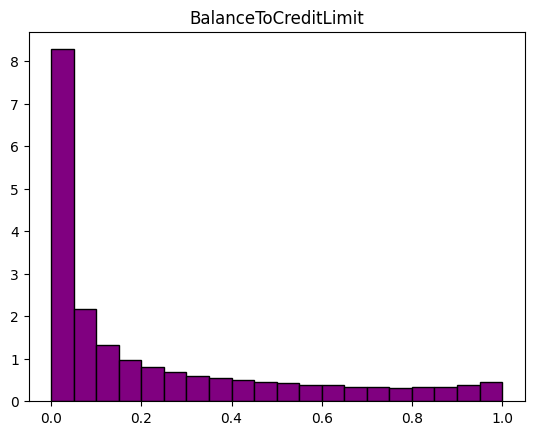

In [ ]:
print('BalanceToCreditLimit before:')
print('<= 1:', data[data['BalanceToCreditLimit'] <= 1].shape[0])
print('> 1:', data[data['BalanceToCreditLimit'] > 1].shape[0])

df.loc[df['BalanceToCreditLimit'] > 1, 'BalanceToCreditLimit'] /= 100

plt.hist(df['BalanceToCreditLimit'][df['BalanceToCreditLimit'] <= 1], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('BalanceToCreditLimit')

print('BalanceToCreditLimit after:')
print('<= 1:', df[df['BalanceToCreditLimit'] <= 1].shape[0])
print('> 1:', df[df['BalanceToCreditLimit'] > 1].shape[0])

Распределение дохода (Income) среди клиентов похоже на нормальное распределение. Пропуски заменим на среднее значение.

max:  1805573.35226


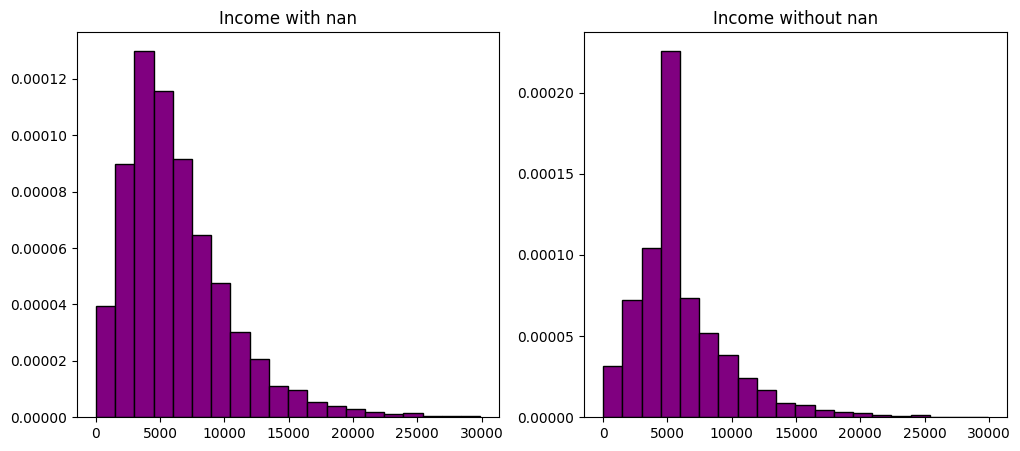

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.hist(df['Income'][df['Income'] <= 30000], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('Income with nan')

print('max: ', df['Income'].max())

Q1 = data['Income'].quantile(0.25)
Q3 = data['Income'].quantile(0.75)
IQR = Q3 - Q1
df['Income'] = df['Income'].fillna(df['Income'][(df['Income'] >= (Q1 - 1.5 * IQR)) & (df['Income'] <= (Q3 + 1.5 * IQR))].mean())

plt.subplot(1, 2, 2)
plt.hist(df['Income'][df['Income'] <= 30000], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('Income without nan')
plt.show()

Значение признака Num60-89Delinquencies для большинства записей равно 0

max: 98
0: 71161
1: 2888
2: 568
> 2: 383


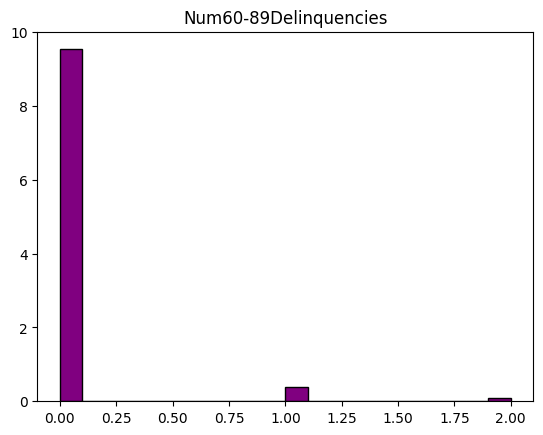

In [306]:
plt.hist(df['Num60-89Delinquencies'][df['Num60-89Delinquencies'] < 3], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('Num60-89Delinquencies')

print('max:', df['Num60-89Delinquencies'].max())
print('0:', df[df['Num60-89Delinquencies'] == 0].shape[0])
print('1:', df[df['Num60-89Delinquencies'] == 1].shape[0])
print('2:', df[df['Num60-89Delinquencies'] == 2].shape[0])
print('> 2:', df[df['Num60-89Delinquencies'] > 2].shape[0])


Значение признака Num30-59Delinquencies для большинства записей также равно 0

max: 98
0: 63012
1: 8002
2: 2305
> 2: 1681


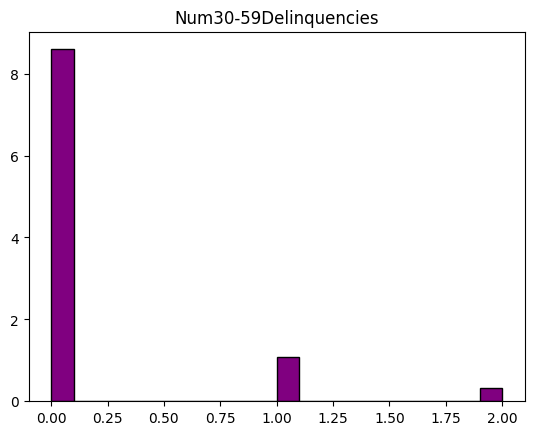

In [307]:
plt.hist(df['Num30-59Delinquencies'][df['Num30-59Delinquencies'] < 3], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('Num30-59Delinquencies')

print('max:', df['Num30-59Delinquencies'].max())
print('0:', df[df['Num30-59Delinquencies'] == 0].shape[0])
print('1:', df[df['Num30-59Delinquencies'] == 1].shape[0])
print('2:', df[df['Num30-59Delinquencies'] == 2].shape[0])
print('> 2:', df[df['Num30-59Delinquencies'] > 2].shape[0])

Больше половины записей имеют значения признака NumDependents равным 0, а также почти все значения NumDependents в датасете <= 4. Можно предположить, что пропущенные значения на самом деле должны быть 0. 

max: 20
0: 45246
1: 13308
2: 9928
> 4: 465


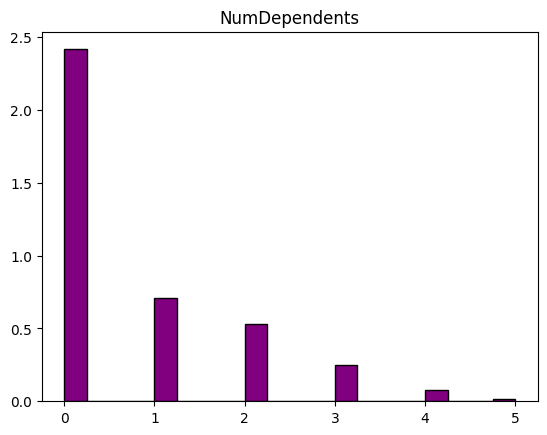

In [308]:
df['NumDependents'] = df['NumDependents'].fillna(0)

plt.hist(df['NumDependents'][df['NumDependents'] < 6], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('NumDependents')

print('max:', df['NumDependents'].max())
print('0:', df[df['NumDependents'] == 0].shape[0])
print('1:', df[df['NumDependents'] == 1].shape[0])
print('2:', df[df['NumDependents'] == 2].shape[0])
print('> 4:', df[df['NumDependents'] > 4].shape[0])

Почти все значения признака NumRealEstateLoans <= 4 

max: 32
0: 28046
1: 26332
2: 15707
3: 3106
> 4: 744


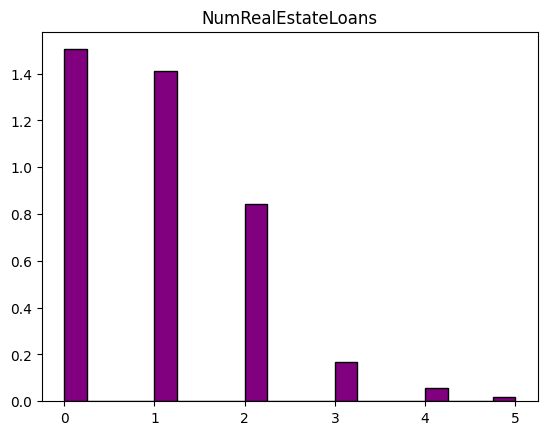

In [310]:
plt.hist(df['NumRealEstateLoans'][df['NumRealEstateLoans'] < 6], density=True, color = 'purple', edgecolor = 'black', bins=20)
plt.title('NumRealEstateLoans')

print('max:', df['NumRealEstateLoans'].max())
print('0:', df[df['NumRealEstateLoans'] == 0].shape[0])
print('1:', df[df['NumRealEstateLoans'] == 1].shape[0])
print('2:', df[df['NumRealEstateLoans'] == 2].shape[0])
print('3:', df[df['NumRealEstateLoans'] == 3].shape[0])
print('> 4:', df[df['NumRealEstateLoans'] > 4].shape[0])

##### Ящики с усами 

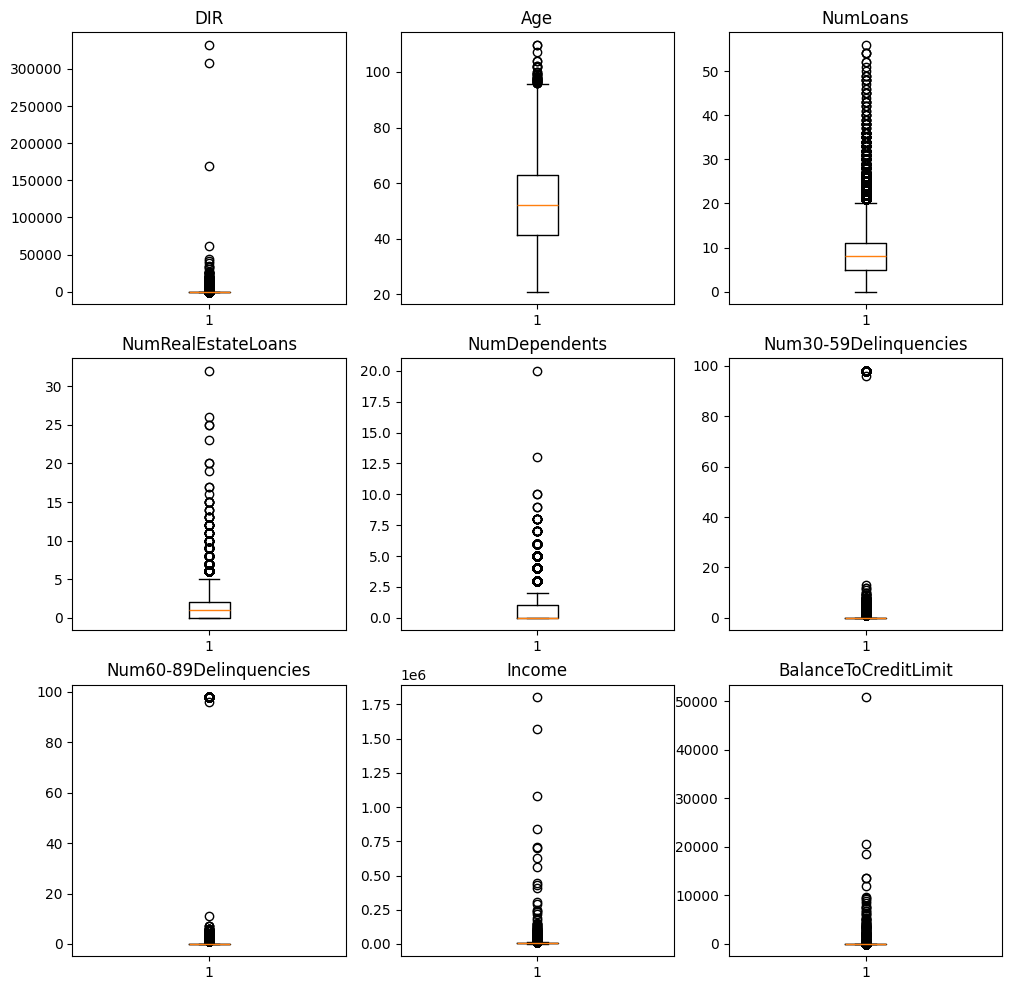

In [285]:
plt.figure(figsize=(12,12))
i = 1
for column in df.columns:
    if column != 'client_id' and column != 'Delinquent90':
        plt.subplot(3, 3, i)
        plt.boxplot(df[column])
        plt.title(column)
        i += 1
plt.show()

Как можно видеть по ящикам с усами, все признаки имеют выбросы. 

##### Тепловая карта

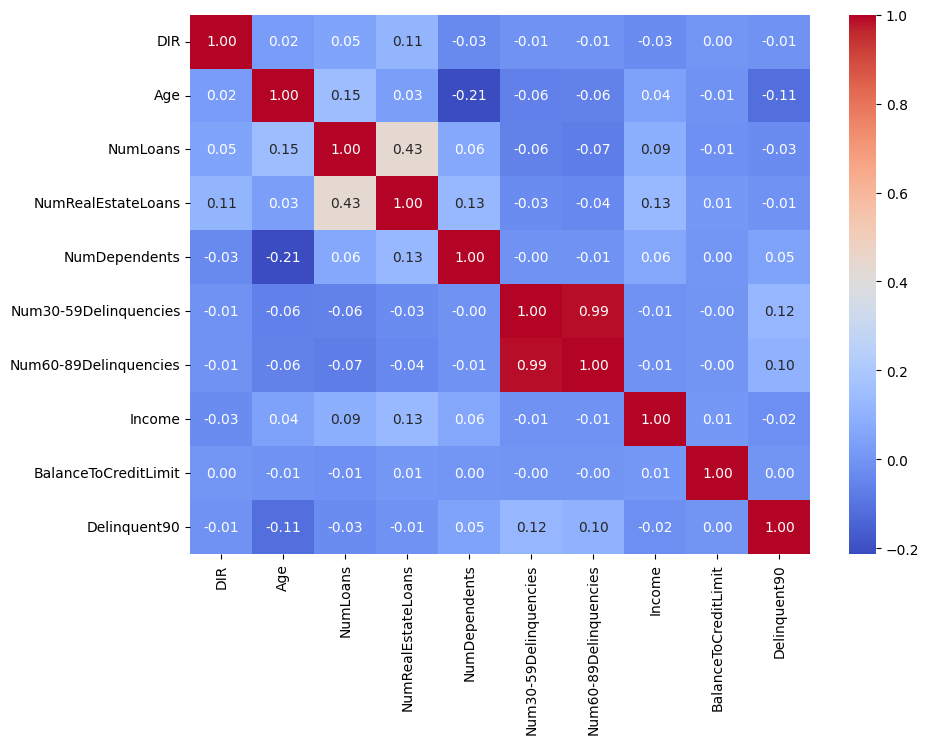

In [286]:
import seaborn as sns


corr_matrix = data.loc[:, df.columns != 'client_id'].corr()
plt.figure(figsize=(10, 7))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.show()

По тепловой карте видно, что в датасете нет сильно коррелированных признаков. Максимальный коэффициент корреляции наблюдается между признаками NumLoans и NumRealEstateLoans.

##### Нормализация данных 

Будем использовать Robust Scaling, так как в данных присутствуют выбросы. 

In [313]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

X_train, X_test, y_train, y_test = train_test_split(
    df.drop(['Delinquent90', 'client_id'], axis=1), 
    df['Delinquent90'], 
    test_size=0.2
)

scaler = RobustScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

#### 1) Дерево решений:

In [326]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, plot_tree

for i in range(1, 12): 
    model = DecisionTreeClassifier(criterion='gini', max_depth=i)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)

    print(f"Глубина = {i}: test: {accuracy_score(y_test, y_test_pred):.4f}, train: {accuracy_score(y_train, y_train_pred):.3f}")

    # if i == 3:
    #     plt.figure(figsize=(17, 6))
    #     plot_tree(model, 
    #       feature_names = df.drop('Delinquent90', axis=1).columns.tolist(),
    #       class_names=['не было', 'были'], 
    #       filled=True, 
    #       rounded=True,
    #       fontsize=10) 
    #     plt.show()

Глубина = 1: test: 0.9301, train: 0.934
Глубина = 2: test: 0.9301, train: 0.934
Глубина = 3: test: 0.9316, train: 0.935
Глубина = 4: test: 0.9321, train: 0.936
Глубина = 5: test: 0.9323, train: 0.937
Глубина = 6: test: 0.9314, train: 0.938
Глубина = 7: test: 0.9312, train: 0.939
Глубина = 8: test: 0.9305, train: 0.941
Глубина = 9: test: 0.9303, train: 0.943
Глубина = 10: test: 0.9301, train: 0.946
Глубина = 11: test: 0.9295, train: 0.950


Таким образом, оптимальной является глубина дерева, равная 4 или 5, так как при такой глубине точность на тестовой выборке максимальна и не сильно меньше точности на обучающей выборке. При большей глубине дерева можно наблюдать переобучение. 

##### Подбор оптимальных параметров дерева с помощью GridSearhCV

Fitting 5 folds for each of 22 candidates, totalling 110 fits
Лучшие параметры: {'criterion': 'gini', 'max_depth': 4}
Точность на test: 0.93


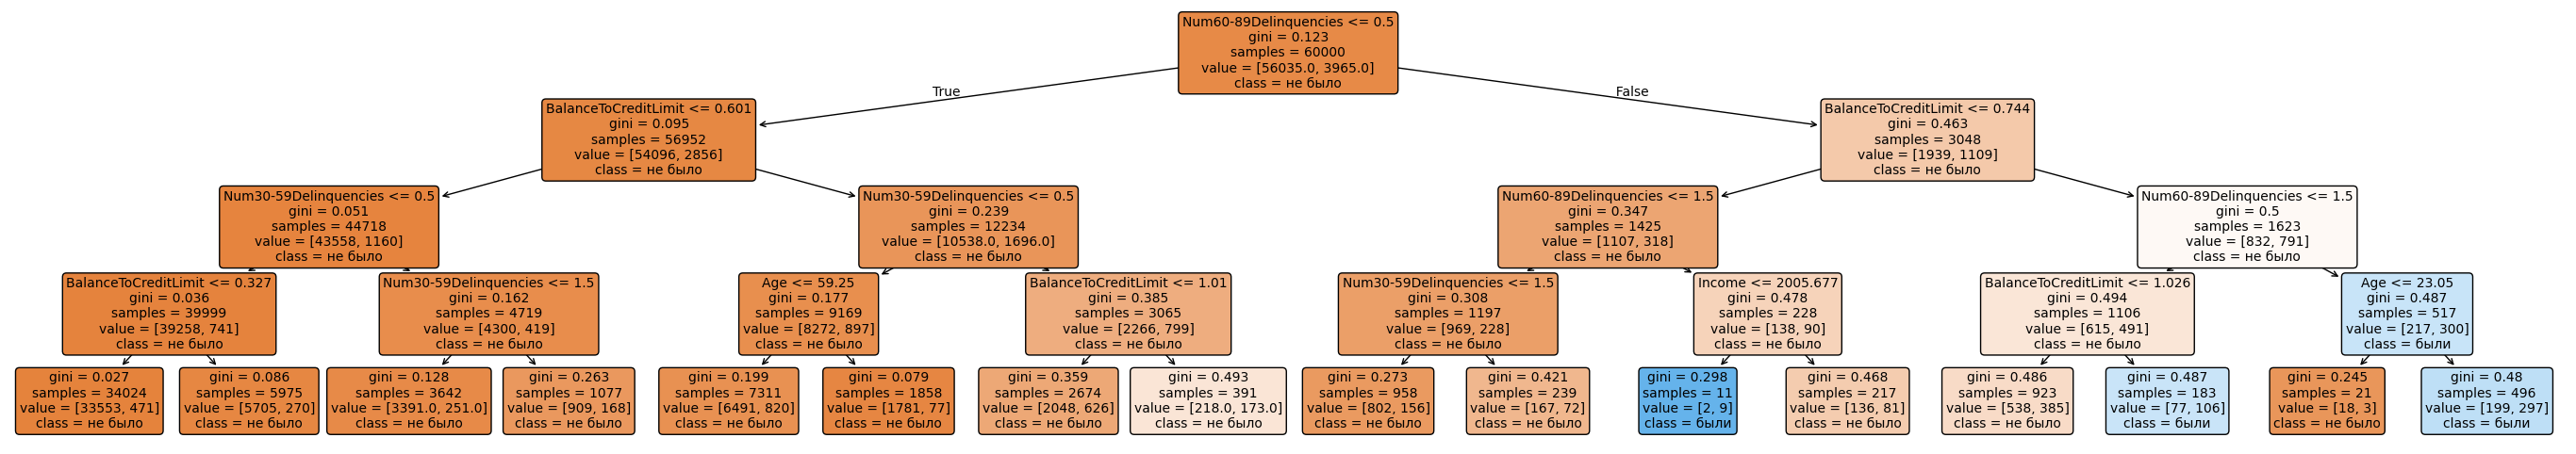

In [339]:
from sklearn.model_selection import GridSearchCV


tree = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [i for i in range(1, 12)]
}

grid_search = GridSearchCV(estimator=tree, param_grid=param_grid, n_jobs=-1, scoring='accuracy', verbose=1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_tree = grid_search.best_estimator_
y_pred = best_tree.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на test: {accuracy:.2f}")

plt.figure(figsize=(35, 6))
plot_tree(best_tree, 
    feature_names = df.drop(['Delinquent90', 'client_id'], axis=1).columns.tolist(),
    class_names=['не было', 'были'], 
    filled=True, 
    rounded=True,
    fontsize=10) 
plt.show()

Оптимальная глубина дерева, найденная с помощью GridSearhCV, равна 4, что совпадает с нашим предположением. На схеме представлена работа лучшего решающего дерева. 

#### 3) Ансамблевые методы

##### Бэггинг

In [ ]:
from sklearn.ensemble import BaggingClassifier


bagging_classifier = BaggingClassifier(best_tree)

param_grid = {
    'n_estimators': [10, 50, 100, 200],  # количество деревьев   
    'max_samples': [0.5, 0.7, 1.0],  # доля объектов для обучения каждого дерева 
    'max_features': [0.5, 0.7, 1.0],  # доля признаков для обучения каждого дерева 
    'bootstrap': [True, False],  # бутстрэп выборка или нет 
    'bootstrap_features': [True, False]  # бутсрэп признаки или нет   
}

grid_search = GridSearchCV(bagging_classifier, param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая оценка:", grid_search.best_score_)

best_bagging_classifier = grid_search.best_estimator_
best_bagging_classifier.fit(X_train, y_train)

y_pred = best_bagging_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность на тестовой выборке: {accuracy}")

Лучшие параметры: {'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 50}
Лучшая оценка: 0.9356833333333332
Точность на тестовой выборке: 0.9323333333333333


##### Стекинг
В качестве базовых моделей выберем 3 модели - логистическую регрессию, SVM и k-NN, а в качестве мета-модели - логистическую регрессию 

In [348]:
from sklearn.linear_model import LogisticRegression


logistic_regression = LogisticRegression()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Параметр регуляризации
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],  # Тип регуляризации
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],  # Алгоритм оптимизации
    'max_iter': [100, 200, 500],  # Максимальное количество итераций
    'class_weight': [None, 'balanced']  # Балансировка классов
}

grid_search = GridSearchCV(
    estimator=logistic_regression,
    param_grid=param_grid,
    scoring='accuracy', 
    n_jobs=-1 
)

grid_search.fit(X_train_scaled, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_logistic_regression = grid_search.best_estimator_
y_pred = best_logistic_regression.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовых данных: {accuracy:.4f}")

/Users/olgashtykina/Desktop/ИТМО /Машинное обучение/Lab3/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/olgashtykina/Desktop/ИТМО /Машинное обучение/Lab3/venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver opti

Лучшие параметры: {'C': 0.001, 'class_weight': None, 'max_iter': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy на тестовых данных: 0.9299


In [353]:
from sklearn.svm import SVC


param_grid = {
    'C': [0.1, 1, 10]  # параметр регуляризации 
}

svc = SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

best_svc = grid_search.best_estimator_
y_pred = best_svc.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовых данных: {accuracy:.4f}")

Лучшие параметры: {'C': 0.1}
Accuracy на тестовых данных: 0.9301


In [355]:
from sklearn.neighbors import KNeighborsClassifier


param_grid = {
    'n_neighbors': range(1, 21),  # количество соседей 
    'weights': ['uniform', 'distance'],  # способ учета веса соседей
    'metric': ['euclidean', 'manhattan', 'minkowski']  # метрика расстояния 
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовых данных: {accuracy:.4f}")

Лучшие параметры: {'metric': 'euclidean', 'n_neighbors': 14, 'weights': 'uniform'}
Accuracy на тестовых данных: 0.9310


In [ ]:
from mlxtend.classifier import StackingClassifier


base_models = [
    best_logistic_regression,  
    best_svc,  
    best_knn  
]

meta_model = LogisticRegression()

stacking_model = StackingClassifier(classifiers=base_models, meta_classifier=meta_model)

param_grid = {
    'meta_classifier__C': [0.1, 1, 10]  # Параметр регуляризации для мета-модели
}

grid_search = GridSearchCV(
    estimator=stacking_model,
    param_grid=param_grid,
    scoring='accuracy',
    n_jobs=-1  
)

grid_search.fit(X_train_scaled, y_train)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

best_stacking = grid_search.best_estimator_
y_pred = best_stacking.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Точность модели на тестовых данных: {accuracy:.2f}")

Лучшие параметры: {'meta_classifier__C': 0.1}
Точность модели на тестовых данных: 0.93


##### Случайный лес 

In [363]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

param_grid = {
    'n_estimators': [50, 100, 200],  # Количество деревьев в лесе
    'max_depth': [4, 5],  # Максимальная глубина дерева
    'bootstrap': [True, False]        # Использование bootstrap выборок
}

grid_search = GridSearchCV(
    estimator=random_forest,  
    param_grid=param_grid,
    scoring='accuracy',            
    n_jobs=-1                 
)

grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy на тестовых данных: {accuracy:.4f}")

Лучшие параметры: {'bootstrap': True, 'max_depth': 5, 'n_estimators': 200}
Accuracy на тестовых данных: 0.9321


##### XGBoost

In [368]:
import xgboost as xgb

model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, learning_rate=0.1, max_depth=5)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

importance = model.get_booster().get_score(importance_type='weight')

sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)

for feature, score in sorted_importance:
    print(f"Feature: {feature}, F score: {score}")

Accuracy: 0.9326
Feature: Age, F score: 509.0
Feature: DIR, F score: 493.0
Feature: Income, F score: 440.0
Feature: BalanceToCreditLimit, F score: 386.0
Feature: NumLoans, F score: 308.0
Feature: Num30-59Delinquencies, F score: 171.0
Feature: NumRealEstateLoans, F score: 134.0
Feature: Num60-89Delinquencies, F score: 119.0
Feature: NumDependents, F score: 76.0
